Uncomment if you are using colab:

In [ ]:
# !pip install pymorphy2==0.9.1
# !pip install gensim==4.1.2

In [2]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import re
from typing import Dict, Iterable, List

import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
aimport plotly
import pymorphy2
from IPython.display import display
from scipy.stats import pearsonr, spearmanr
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate
from tqdm import tqdm_notebook

plt.style.use("ggplot")
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vald_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vald_\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [4]:
SEED = 42
np.random.seed(SEED)

DATA_PATH = "./data/w2v_dataset.csv.zip"
EVAL_PATH = "./data/ru_simlex965.tsv"

Uncomment if you are using colab:

In [5]:
# !mkdir ./data
# !wget https://raw.githubusercontent.com/vadim0912/ML2023/master/lecture08/data/w2v_dataset.csv.zip -O $DATA_PATH
# !wget https://raw.githubusercontent.com/vadim0912/ML2023/master/lecture08/data/ru_simlex965.tsv -O $EVAL_PATH

# Dataset

In [6]:
df = pd.read_csv(DATA_PATH)

df.head()

,sentence,language
0,После увольнения я решил собрать своих друзей ...,ru
1,"Ты знаешь , что это не гнев заставил моё сердц...",ru
2,Просто има толкова много други хора в пъпа ти ...,bg
3,"Ради всех имён , которые я никогда не узнаю , ...",ru
4,Ми пропускаємо найважливіші для нас речі . Най...,uk


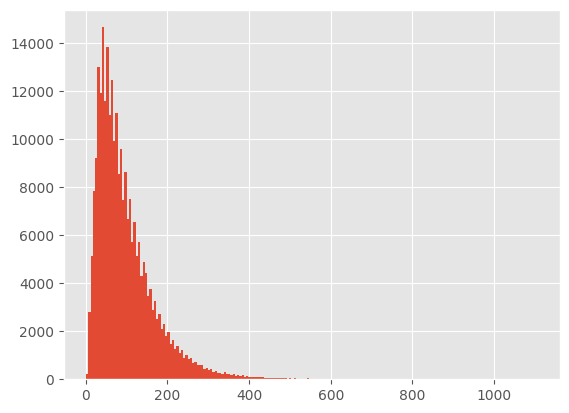

In [7]:
df.sentence.str.len().hist(bins=200);

In [8]:
df.language.value_counts()

ru    106970
bg     89752
uk     56123
mk     12887
be      2587
Name: language, dtype: int64

In [9]:
df.shape

(268319, 2)

In [10]:
corpus = df.sentence.values

# Preprocessing

In [11]:
char2count = df.sentence.apply(lambda x: list(x.lower())).explode().value_counts()

"".join(char2count.index)

' оаеитнсврмлкдпу,зябг.чіьыжхйшцющъo;&tuэqф-є0ё?ї:)(—ј1a2sep«»953ir4♫nќ8lc6dў7–!њgm#hb%ѓfykw“„xv♪ґ’…”/zџjèѝљ́$ó`+ѕ=ѐá№é\u200b@°‘^‐_―‒*−íçýอ²̶~"½×ü©º¾ยรò่™\\\ufeffà¼öτ∇¥•®¶æãêā－\x7f{ْō\u202eðë¿ش̀}'

In [12]:
def tokenize(text: str) -> List[str]:
    return re.findall("[оаеитнсврмлкдпузябгчіьыжхйшцющъoэфєёї]+", text.lower())

In [13]:
stopword_set = set(nltk.corpus.stopwords.words("russian"))

In [14]:
lemmatizer = pymorphy2.MorphAnalyzer()

lemmatizer_cache = {}


def lemmatize(token: str) -> str:
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

In [15]:
def prepare_sentence_dataset(documents: Iterable[str]) -> List[List[str]]:
    tokenized_sentences = []
    for document in tqdm_notebook(documents):
        for sentence in nltk.sent_tokenize(document):
            lemmatized_tokens = [lemmatize(token) for token in tokenize(sentence)]
            tokenized_sentences.append(
                [token for token in lemmatized_tokens if token not in stopword_set]
            )
    return tokenized_sentences

In [16]:
sentence_dataset = prepare_sentence_dataset(corpus)

C:\Users\vald_\AppData\Local\Temp\ipykernel_16736\1901367261.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for document in tqdm_notebook(documents):


  0%|          | 0/268319 [00:00<?, ?it/s]

In [17]:
len(sentence_dataset)

322785

In [18]:
corpus[4]

'Ми пропускаємо найважливіші для нас речі . Найжахливіше , що всі вважають , що таким є справжнє життя , і ми повинні пристосуватися до нього .'

In [19]:
sentence_dataset[4]

['ми', 'пропускаємо', 'найважливіші', 'речі']

# Word2Vec training

In [20]:
word2vec = gensim.models.Word2Vec(
    vector_size=100, sg=0, window=5, min_count=5, negative=20
)

In [21]:
word2vec.build_vocab(sentence_dataset)

In [22]:
len(word2vec.wv.index_to_key)

45406

In [23]:
%%time

word2vec.train(sentence_dataset, total_examples=word2vec.corpus_count, epochs=30);

CPU times: total: 7min 37s
Wall time: 2min 34s


In [24]:
word2vec.wv.most_similar("мама")

[('подруга', 0.7363934516906738),
 ('дочка', 0.6943654417991638),
 ('дружина', 0.6034971475601196),
 ('сестра', 0.5763906240463257),
 ('сын', 0.5762844085693359),
 ('тато', 0.5651463866233826),
 ('жінка', 0.5578761696815491),
 ('дядя', 0.5570032000541687),
 ('бабушка', 0.5530890226364136),
 ('малыш', 0.5476768016815186)]

In [25]:
test_words = ["можливість", "чоловік", "возможность", "мужчина"]

for word in test_words:
    print(word)
    print(
        tabulate(
            word2vec.wv.most_similar(word),
            tablefmt="orgtbl",
            headers=("neighbor", "score"),
        ),
        end="\n\n",
    )

можливість
| neighbor   |    score |
|------------+----------|
| змогу      | 0.82242  |
| змоги      | 0.723362 |
| здатність  | 0.669758 |
| можливості | 0.656209 |
| капітал    | 0.655754 |
| бажання    | 0.645448 |
| аби        | 0.637957 |
| надію      | 0.631575 |
| намір      | 0.626671 |
| інформацію | 0.624034 |

чоловік
| neighbor   |    score |
|------------+----------|
| хлопець    | 0.812157 |
| лікар      | 0.758554 |
| чоловіка   | 0.732154 |
| молодий    | 0.698537 |
| юнак       | 0.697251 |
| дядько     | 0.695275 |
| батька     | 0.693837 |
| хлопчина   | 0.68633  |
| дідусь     | 0.684852 |
| джонні     | 0.684319 |

возможность
| neighbor     |    score |
|--------------+----------|
| позволять    | 0.682035 |
| должный      | 0.673103 |
| смочь        | 0.669388 |
| также        | 0.662561 |
| который      | 0.658881 |
| преимущество | 0.649867 |
| опыт         | 0.64537  |
| навык        | 0.645228 |
| уверенность  | 0.637527 |
| улучшение    | 0.634668 |

мужчин

# Visualization

In [26]:
index2word = np.array(word2vec.wv.index_to_key)

In [42]:
index2word

array(['o', 'сие', 'это', ..., 'великденския', 'розгадати', 'пеейки'],
      dtype='<U22')

In [27]:
embeddings = word2vec.wv.vectors

In [28]:
embeddings.shape

(45406, 100)

In [43]:
embeddings

array([[-0.8799944 , -2.2350945 ,  1.5761698 , ..., -0.07836084,
         2.7791426 ,  3.4239347 ],
       [-4.2578745 ,  0.19588238,  0.08561008, ..., -0.59562445,
        -1.0649539 ,  0.83084756],
       [ 1.6886727 ,  2.0655668 , -1.8481318 , ..., -0.79205626,
        -0.4946203 , -2.9115155 ],
       ...,
       [ 0.01920379,  0.23934773, -0.44320798, ..., -0.09467009,
        -0.33112496, -0.15124367],
       [-0.05032939, -0.437609  ,  0.5831214 , ..., -0.45137993,
         0.5647828 ,  0.2767884 ],
       [ 0.08449546,  0.4799522 , -0.4992523 , ..., -0.08847178,
        -0.2783216 , -0.04157423]], dtype=float32)

In [48]:
from sklearn.model_selection import GridSearchCV

In [ ]:
GridSearchCV()

In [44]:
index2word

array(['o', 'сие', 'это', ..., 'великденския', 'розгадати', 'пеейки'],
      dtype='<U22')

In [29]:
ids = np.random.randint(low=0, high=index2word.size, size=2000)

In [45]:
ids

array([15795,   860, 38158, ..., 29259, 42823, 37208])

In [47]:
embeddings[ids].shape

(2000, 100)

In [30]:
embeddings_reduced = TSNE(random_state=SEED, n_components=2).fit_transform(
    embeddings[ids]
)

In [34]:
embeddings_reduced

array([[  9.466947 ,  11.2604265],
       [-11.767819 ,  22.529503 ],
       [ -9.176619 , -22.845675 ],
       ...,
       [  0.6210703,  13.408725 ],
       [-18.361814 , -15.515482 ],
       [ 15.430258 ,   4.2018523]], dtype=float32)

In [39]:
def plot_tsne_embeddings(embeddings: np.ndarray, annotations: np.ndarray) -> None:
    trace = plotly.graph_objs.Scattergl(
        x=embeddings[:, 0],
        y=embeddings[:, 1],
        name="Embedding",
        mode="markers",
        marker={"colorscale": "Viridis", "size": 6, "line": {"width": 0.5}, "opacity": 0.75},
        text=annotations,
    )

    layout = {
        "title": "Word2Vec 2D TSNE Embeddings",
        "yaxis": {"zeroline": False},
        "xaxis": {"zeroline": False},
        "hovermode": "closest",
        "width": 800,
        "height": 800,
    }

    display(plotly.graph_objs.Figure(data=[trace], layout=layout))

In [40]:
plot_tsne_embeddings(embeddings_reduced, index2word[ids])

# Sentence Embeddings

In [ ]:
def embed_text(
    text: Iterable[str], word2index: Dict[str, int], word_embeddings: np.ndarray
) -> np.ndarray:
    embs = np.array(
        [
            word_embeddings[word2index[word]]
            for word in text
            if word in word2index and word not in stopword_set
        ]
    )

    if embs.shape[0] > 0:
        return embs.mean(0, keepdims=True)
    else:
        return np.zeros((1, word_embeddings.shape[1]))

In [ ]:
word2index = word2vec.wv.key_to_index

In [ ]:
talks = [
    [lemmatize(token) for token in tokenize(text) if token not in stopword_set]
    for text in corpus
]

In [ ]:
talk2vec = np.concatenate([embed_text(talk, word2index, embeddings) for talk in talks])

In [ ]:
ids = np.random.randint(low=0, high=index2word.size, size=10_000)

talk2vec_reduced = TSNE(n_components=2, random_state=SEED).fit_transform(talk2vec[ids])

plot_tsne_embeddings(talk2vec_reduced, df.sentence.values[ids])

# Evaluation

In [ ]:
eval_set = pd.read_csv(EVAL_PATH, sep="\t")

eval_set.columns = ["word1", "word2", "human_score"]

In [ ]:
mask = eval_set.apply(
    lambda row: (row["word1"] in word2index) & (row["word2"] in word2index), axis=1
)

eval_set = eval_set[mask].reset_index(drop=True)

In [ ]:
eval_set["model_score"] = eval_set.apply(
    lambda row: cosine_similarity(
        embeddings[[word2index[row["word1"]]]], embeddings[[word2index[row["word2"]]]]
    )[0][0],
    axis=1,
)

In [ ]:
plt.scatter(eval_set["model_score"], eval_set["human_score"], alpha=0.8);

In [ ]:
pearsonr(eval_set["model_score"], eval_set["human_score"])

In [ ]:
spearmanr(eval_set["model_score"], eval_set["human_score"])

In [ ]:
eval_set.sort_values("human_score").tail(20).style.background_gradient(
    subset=["model_score"]
)

# Appendix
* FastText: https://arxiv.org/abs/1607.01759
* Byte Pair Encoding:
    * https://arxiv.org/abs/1508.07909
    * https://www.derczynski.com/papers/archive/BPE_Gage.pdf
* Stop Using Word2Vec: https://multithreaded.stitchfix.com/blog/2017/10/18/stop-using-word2vec/